In [1]:
import sys
sys.path.append(r'D:\github\ripple_heterogeneity\python')
import functions,loading,replay_run

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import replay_fig
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
import random

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
# def get_replay_epochs(results,direction,alpha=0.05):

#     if not np.any((direction == 'forward') | (direction == 'reverse')):
#         print('wrong direction')
#         return 
#     starts = [] 
#     stops = []

#     idx = (results[direction]['df'].score_pval_time_swap <= alpha) & (results[direction]['df'].replay_type == direction)
#     starts.append(results[direction]['df'][idx].start)
#     stops.append(results[direction]['df'][idx].stop)

#     idx = (results['inbound_epochs']['df'].score_pval_time_swap <= alpha) & (results['inbound_epochs']['df'].replay_type == direction)
#     starts.append(results['inbound_epochs']['df'][idx].start)
#     stops.append(results['inbound_epochs']['df'][idx].stop)

#     sort_idx = np.argsort(np.hstack(starts))

#     starts = np.hstack(starts)[sort_idx]
#     stops = np.hstack(stops)[sort_idx]

#     return nel.EpochArray(np.array([starts,stops]).T)

def get_replay_epochs(results,replay_type,direction,alpha=0.05):

    if not np.any((replay_type == 'forward') | (replay_type == 'reverse')):
        raise Exception('wrong replay_type')

    if not np.any((direction == 'outbound_epochs') | (direction == 'inbound_epochs')):
        raise Exception('wrong direction')

    idx = (results[direction]['df'].score_pval_time_swap <= alpha) & (results[direction]['df'].replay_type == replay_type)
    starts = results[direction]['df'][idx].start.values
    stops = results[direction]['df'][idx].stop.values

    sort_idx = np.argsort(starts)

    starts = starts[sort_idx]
    stops = stops[sort_idx]

    return nel.EpochArray(np.array([starts,stops]).T)
    
def get_pre_linear_post(basepath):
    epoch_df = loading.load_epoch(basepath)
    pattern_idx,_ = functions.find_epoch_pattern(epoch_df.environment,['sleep','linear','sleep'])
    epoch_df = epoch_df[pattern_idx]
    return epoch_df,nel.EpochArray([np.array([epoch_df.startTime,epoch_df.stopTime]).T])

In [4]:
import warnings
warnings.filterwarnings("ignore", message="All-NaN slice encountered")

importlib.reload(functions)

save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'
sessions = glob.glob(save_path +os.sep+ '*.pkl')

df_rank_order = pd.DataFrame()
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

        basepath = results['outbound_epochs']['session']

        st,cell_metrics = loading.load_spikes(basepath,putativeCellType='Pyr',brainRegion='CA1')

        epochs = {
                'forward_outbound_replay': get_replay_epochs(results,'forward','outbound_epochs'),
                'forward_inbound_replay': get_replay_epochs(results,'forward','inbound_epochs'),
                'reverse_outbound_replay': get_replay_epochs(results,'reverse','outbound_epochs'),
                'reverse_inbound_replay': get_replay_epochs(results,'reverse','inbound_epochs')
                }

        epoch_df,behavior_epochs = get_pre_linear_post(basepath)

        median_rank_order = []
        label = []
        deepSuperficial = []
        uid = []
        environment = []
        for beh_i,beh_epoch in enumerate(behavior_epochs):
            for key_ in  epochs.keys():
                temp_rank_order,rank_order = functions.get_rank_order(st[beh_epoch],epochs[key_])
                median_rank_order.append(temp_rank_order)
                label.append([key_]*len(temp_rank_order))
                deepSuperficial.append(cell_metrics.deepSuperficial)
                uid.append(cell_metrics.UID)
                environment.append([beh_i]*len(temp_rank_order))

        df_rank_order_temp = pd.DataFrame()
        df_rank_order_temp['median_rank_order'] = np.hstack(median_rank_order)
        df_rank_order_temp['label'] = np.hstack(label)
        df_rank_order_temp['basepath'] = basepath
        df_rank_order_temp['deepSuperficial'] = np.hstack(deepSuperficial)
        df_rank_order_temp['UID'] = np.hstack(uid)
        df_rank_order_temp['environment'] = np.hstack(environment)

    df_rank_order = pd.concat([df_rank_order,df_rank_order_temp])

df_rank_order['label_lay'] = df_rank_order['label'] + df_rank_order['deepSuperficial']


## make example plots

In [6]:
sessions

['Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Achilles_Achilles_10252013.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Achilles_Achilles_11012013.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Buddy_Buddy_06272013.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Cicero_Cicero_09012014.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Cicero_Cicero_09102014.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Cicero_Cicero_09172014.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Gatsby_Gatsby_08022013.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_GrosmarkAD_Gatsby_Gatsby_08282013.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\replay\\Z__Data_HMC1_day8.pkl',
 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\repl

In [8]:
with open(sessions[0], 'rb') as f:
    results = pickle.load(f)
    
basepath = results['outbound_epochs']['session']

st,cell_metrics = loading.load_spikes(basepath,putativeCellType='Pyr',brainRegion='CA1')

epochs = {
        'forward_outbound_replay': get_replay_epochs(results,'forward','outbound_epochs'),
        'forward_inbound_replay': get_replay_epochs(results,'forward','inbound_epochs'),
        'reverse_outbound_replay': get_replay_epochs(results,'reverse','outbound_epochs'),
        'reverse_inbound_replay': get_replay_epochs(results,'reverse','inbound_epochs')
        }

epoch_df,behavior_epochs = get_pre_linear_post(basepath)

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[0]],epochs['forward_outbound_replay'])


Text(0.5, 1, 'ripple psth during sorted by rank order for reverse_outbound_replay during linear')

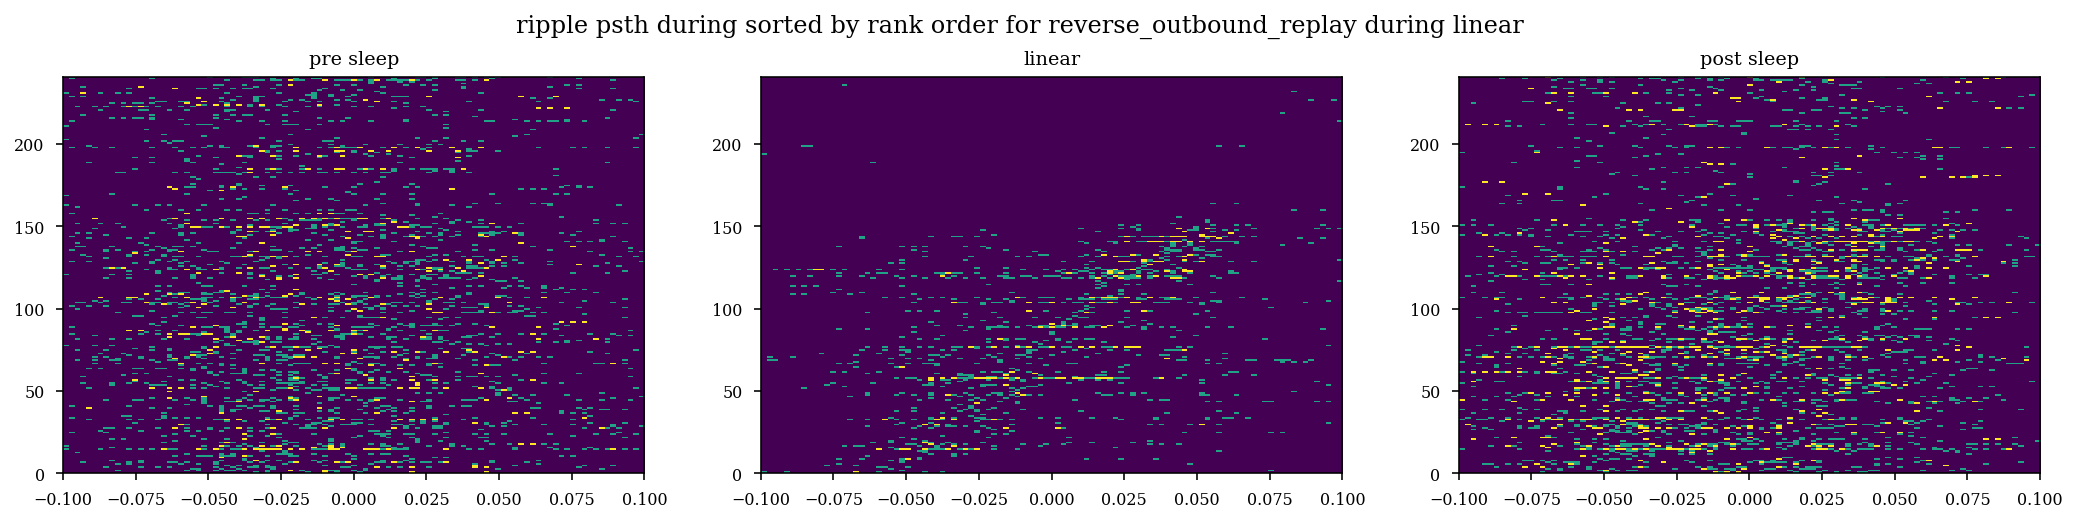

In [9]:
fig, axs = plt.subplots(1,3, figsize=functions.set_size('thesis', fraction=3, subplots=(1,3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.2)
axs = axs.ravel()

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['reverse_outbound_replay'])

ccg = functions.compute_psth(st[behavior_epochs[0]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[0].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[1].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[2]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[2].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

axs[0].set_title('pre sleep')
axs[1].set_title('linear')
axs[2].set_title('post sleep')

fig.suptitle('ripple psth during sorted by rank order for reverse_outbound_replay during linear', y=1,fontsize=12)

Text(0.5, 1, 'ripple psth during linear track sorted by rank order for reverse_outbound_replay')

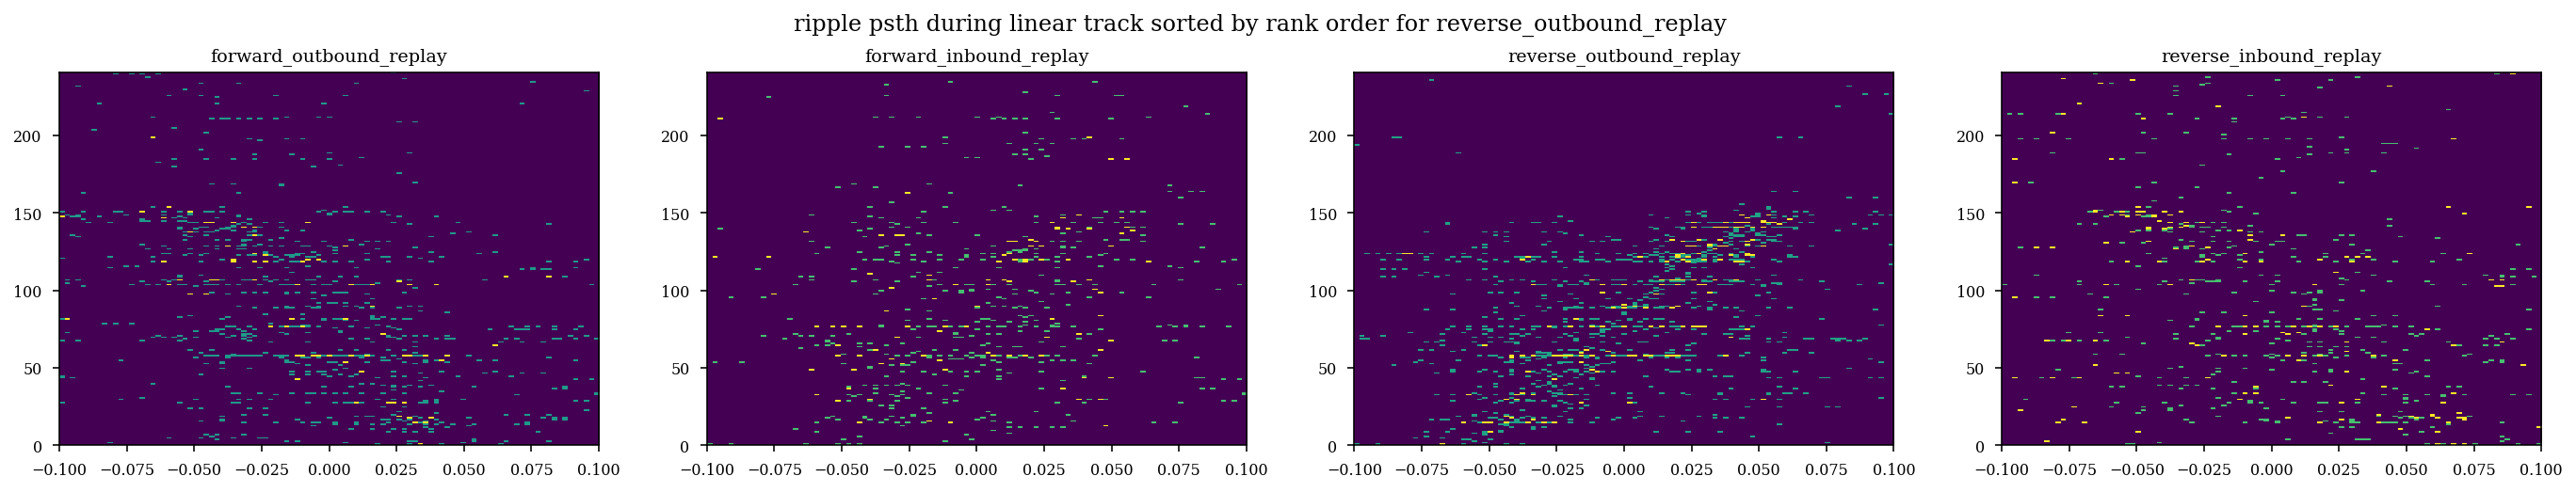

In [10]:
fig, axs = plt.subplots(1,4, figsize=functions.set_size('thesis', fraction=4, subplots=(1,4)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.2)
axs = axs.ravel()

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['reverse_outbound_replay'])

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['forward_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[0].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['forward_inbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[1].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_outbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[2].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

ccg = functions.compute_psth(st[behavior_epochs[1]].data,epochs['reverse_inbound_replay'].centers)
extent = [ccg.index.min(),ccg.index.max(),0,ccg.shape[1]]
axs[3].imshow(ccg[np.argsort(temp_rank_order)].T,aspect='auto',interpolation='nearest',origin='lower',vmax=10,extent=extent)

axs[0].set_title('forward_outbound_replay')
axs[1].set_title('forward_inbound_replay')
axs[2].set_title('reverse_outbound_replay')
axs[3].set_title('reverse_inbound_replay')

fig.suptitle('ripple psth during linear track sorted by rank order for reverse_outbound_replay', y=1,fontsize=12)


In [23]:
epochs

{'forward_outbound_replay': <EpochArray at 0x1da46682a30: 93 epochs> of length 9.4824 seconds,
 'forward_inbound_replay': <EpochArray at 0x1da46682b50: 71 epochs> of length 7.156 seconds,
 'reverse_outbound_replay': <EpochArray at 0x1da446a1190: 87 epochs> of length 9.028 seconds,
 'reverse_inbound_replay': <EpochArray at 0x1da446a1e50: 71 epochs> of length 7.2576 seconds}

Text(0.5, 0.98, 'reverse')

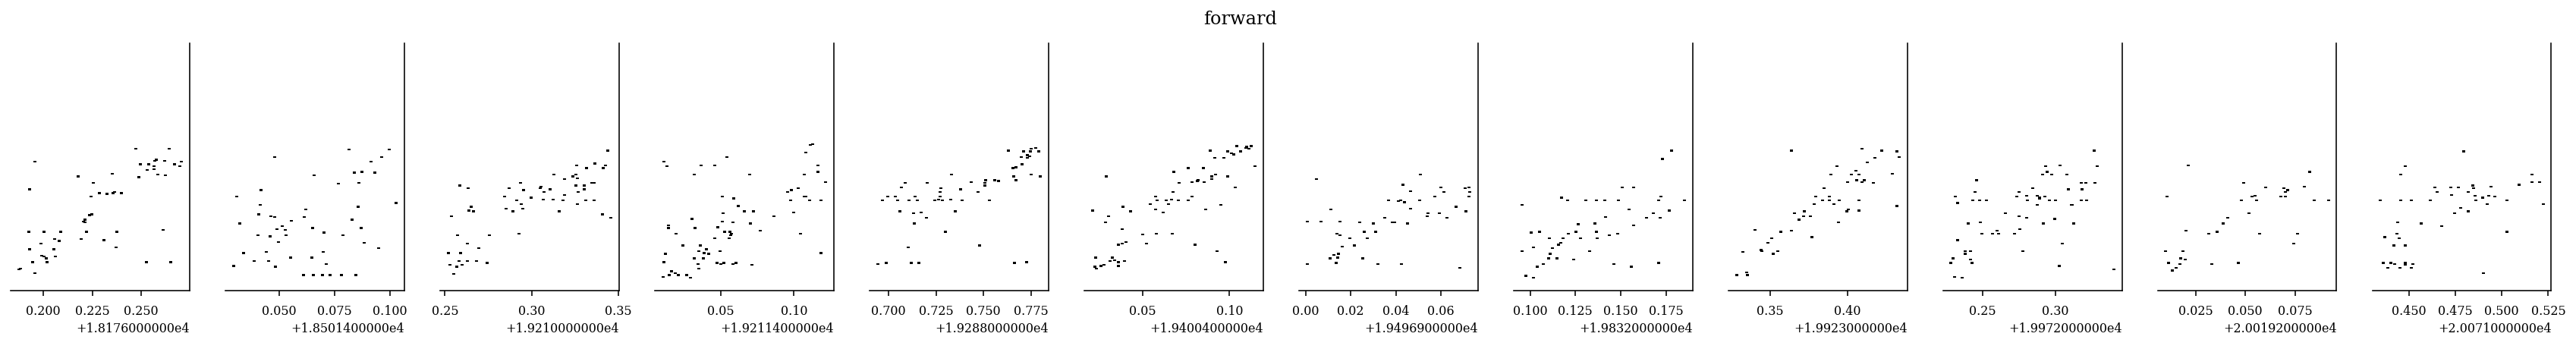

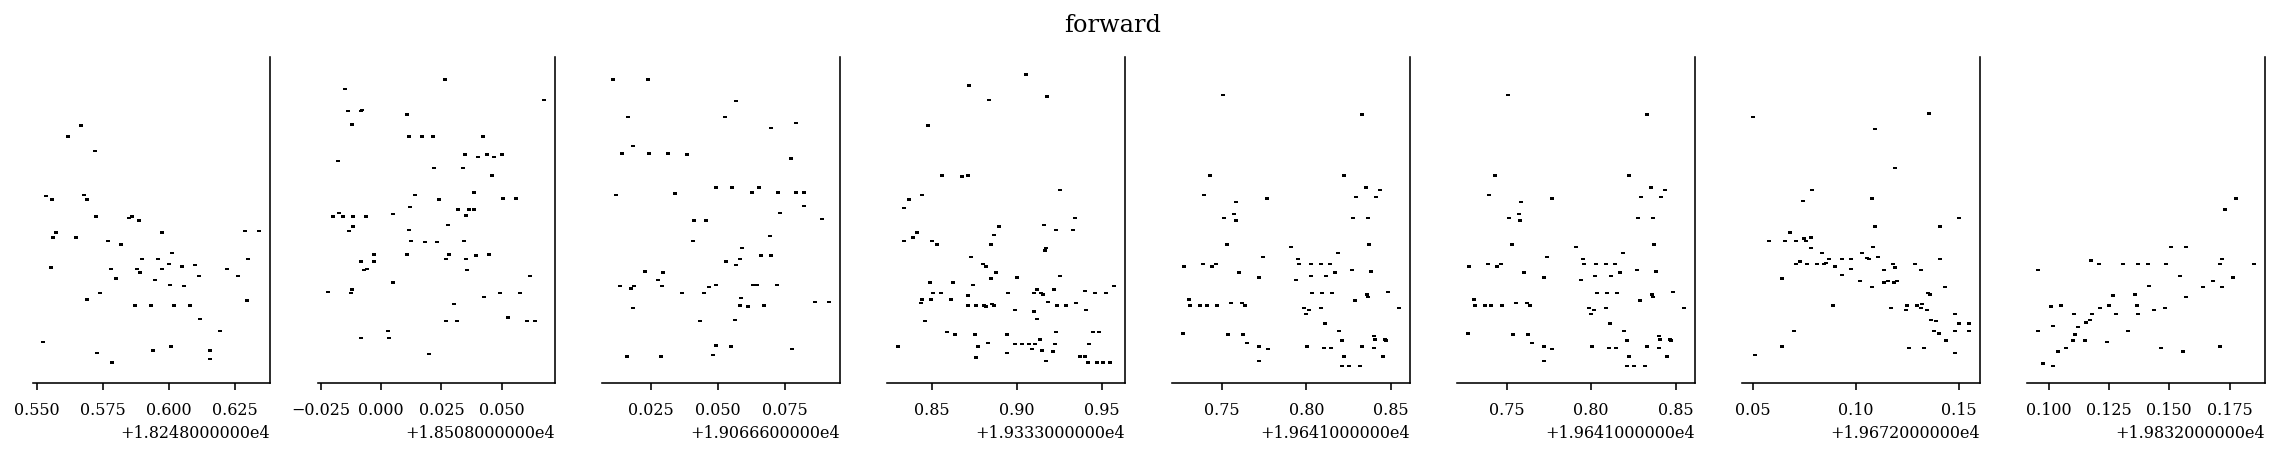

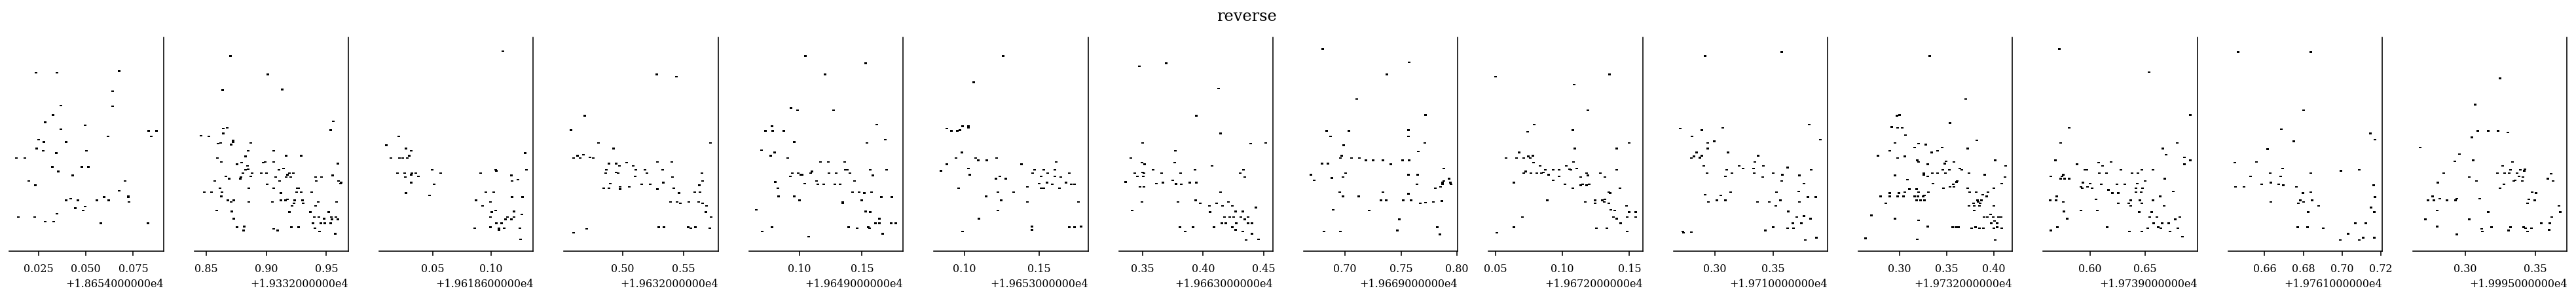

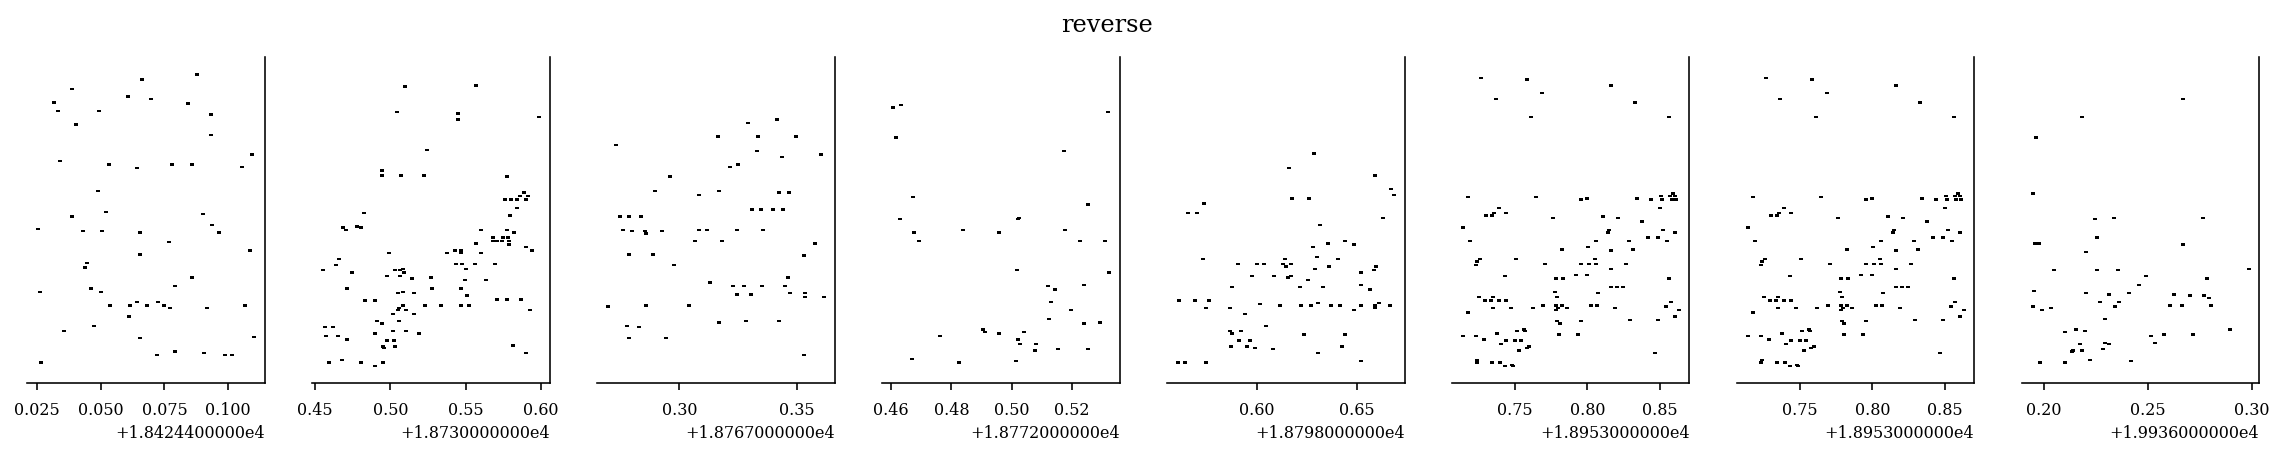

In [26]:
def plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=0,epoch_label='forward_outbound_replay'):

    
    n_intervals = st[behavior_epochs[behavior_epochs_n]][epochs[epoch_label]].n_intervals

    fig,ax = plt.subplots(1,n_intervals,figsize=(25*n_intervals*.1,3))

    for rip in range(n_intervals):
        try:
            ax[rip].eventplot(st[behavior_epochs[behavior_epochs_n]][epochs[epoch_label]][rip].data[np.argsort(temp_rank_order)],
                                linewidths=2,linelengths=2,color='k')
        except:
            pass
        ax[rip].spines["top"].set_visible(False)
        ax[rip].spines["left"].set_visible(False)
        ax[rip].get_yaxis().set_visible(False)

temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])

plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=[1],epoch_label='forward_outbound_replay')
plt.gcf().suptitle('forward')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='forward_inbound_replay')
plt.gcf().suptitle('forward')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='reverse_outbound_replay')
plt.gcf().suptitle('reverse')
plot_rasters(st,behavior_epochs,epochs,temp_rank_order,behavior_epochs_n=1,epoch_label='reverse_inbound_replay')
plt.gcf().suptitle('reverse')


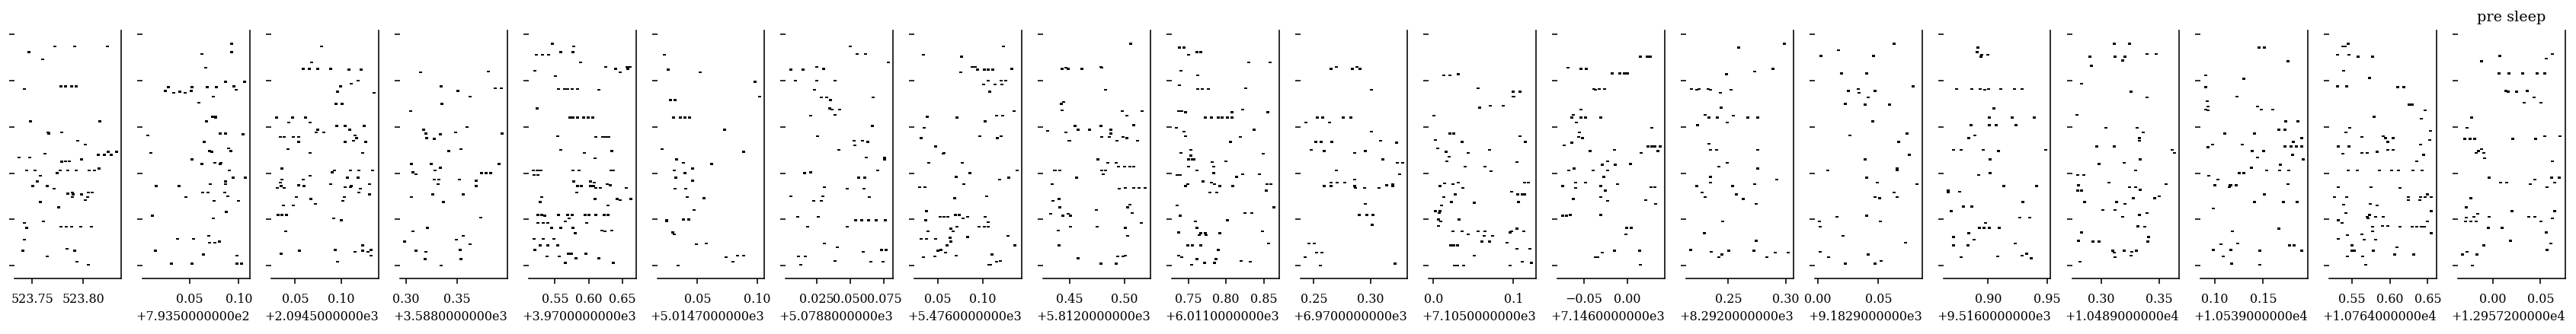

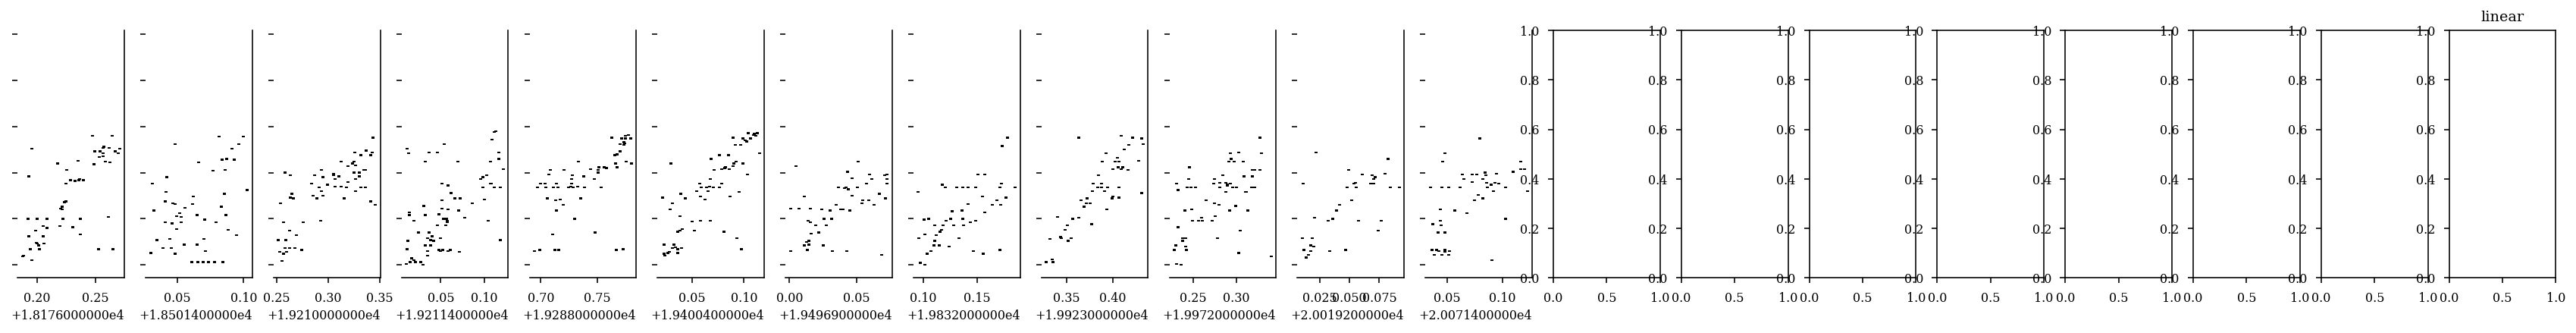

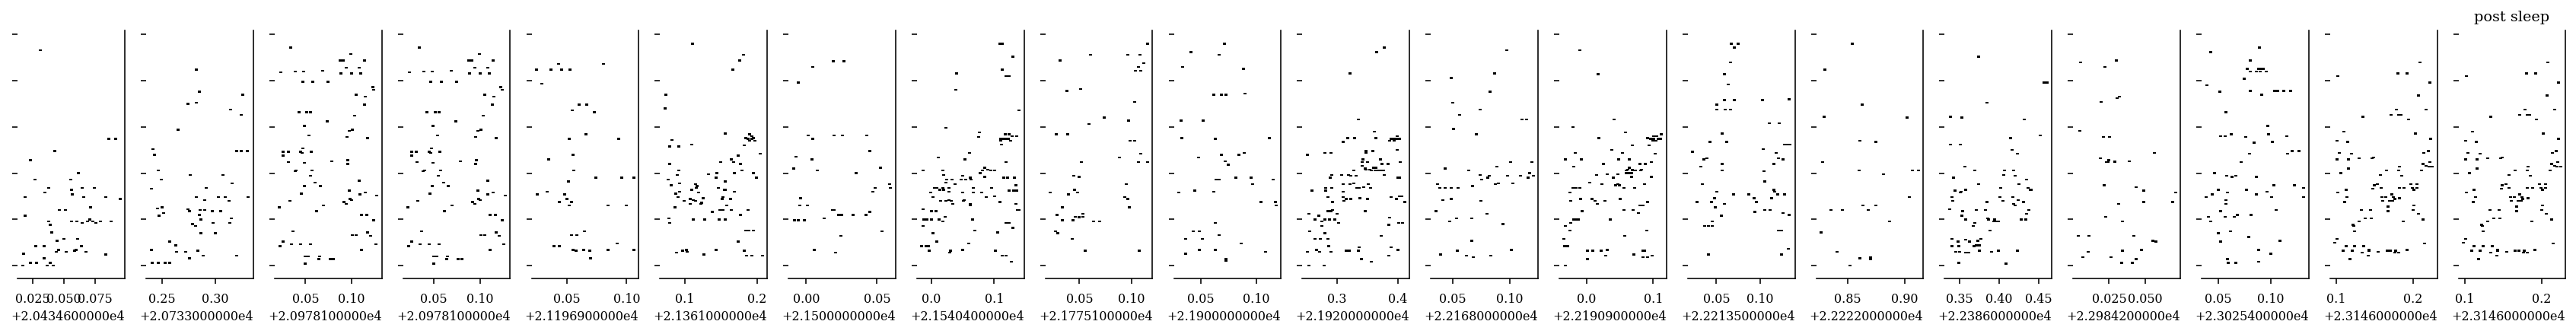

In [14]:
temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])

fig,ax = plt.subplots(1,20,figsize=(30,3))
for rip in range(st[behavior_epochs[0]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[0]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('pre sleep')    
plt.show()

fig,ax = plt.subplots(1,20,figsize=(30,3))
# temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[1]],epochs['forward_outbound_replay'])
for rip in range(st[behavior_epochs[1]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[1]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('linear')    
plt.show()

fig,ax = plt.subplots(1,20,figsize=(30,3))
# temp_rank_order,rank_order = functions.get_rank_order(st[behavior_epochs[2]],epochs['forward_outbound_replay'])
for rip in range(st[behavior_epochs[2]][epochs['forward_outbound_replay']].n_intervals):
    if rip >= 20:
        break
    try:
        ax[rip].eventplot(st[behavior_epochs[2]][epochs['forward_outbound_replay']][rip].data[np.argsort(temp_rank_order)],linewidths=2,linelengths=2,color='k')
    except:
        pass
    ax[rip].spines["top"].set_visible(False)
    ax[rip].spines["left"].set_visible(False)
    ax[rip].set_yticklabels('')
plt.title('post sleep')    
plt.show()

In [15]:
# df_rank_order.aggregate(['basepath','UID'])
# df_rank_order[(df_rank_order.basepath == 'Z:\Data\AYAold\AYA4\day150804') & (df_rank_order.environment == 0) & (df_rank_order.label == 'forward_outbound_replay') ]
# plt.figure()
pre_post_change = []
pre_task_change = []
for basepath in df_rank_order.basepath.unique():
    for label in df_rank_order[(df_rank_order.basepath == basepath) & (df_rank_order.label == 'forward_outbound_replay')].label.unique():
        for UID in df_rank_order[(df_rank_order.basepath == basepath) & (df_rank_order.label == label) & (df_rank_order.label == 'forward_outbound_replay') ].UID.unique():
            median_rank_order = df_rank_order[
                                            (df_rank_order.basepath == basepath) &
                                            (df_rank_order.label == label) &
                                            (df_rank_order.label == 'forward_outbound_replay') &
                                            (df_rank_order.UID == UID)
                                            ].median_rank_order.values
            pre_task_change.append(median_rank_order[1] - median_rank_order[0]) 
            pre_post_change.append(median_rank_order[-1] - median_rank_order[0])                              

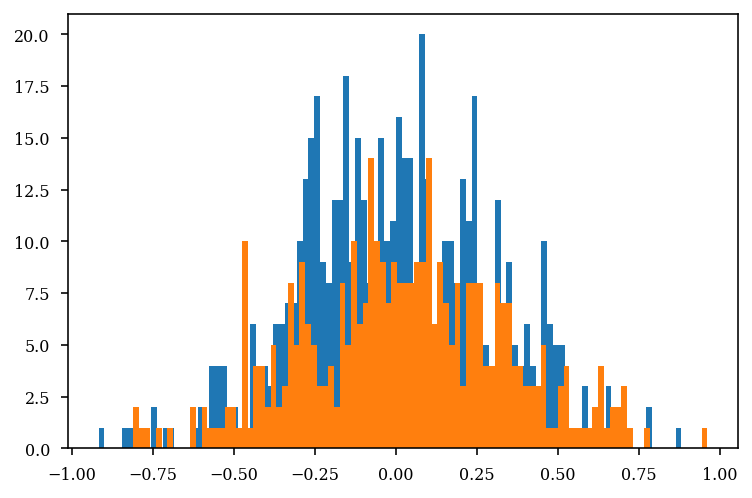

In [16]:
plt.hist(pre_post_change,100)
plt.hist(pre_task_change,100)
plt.show()


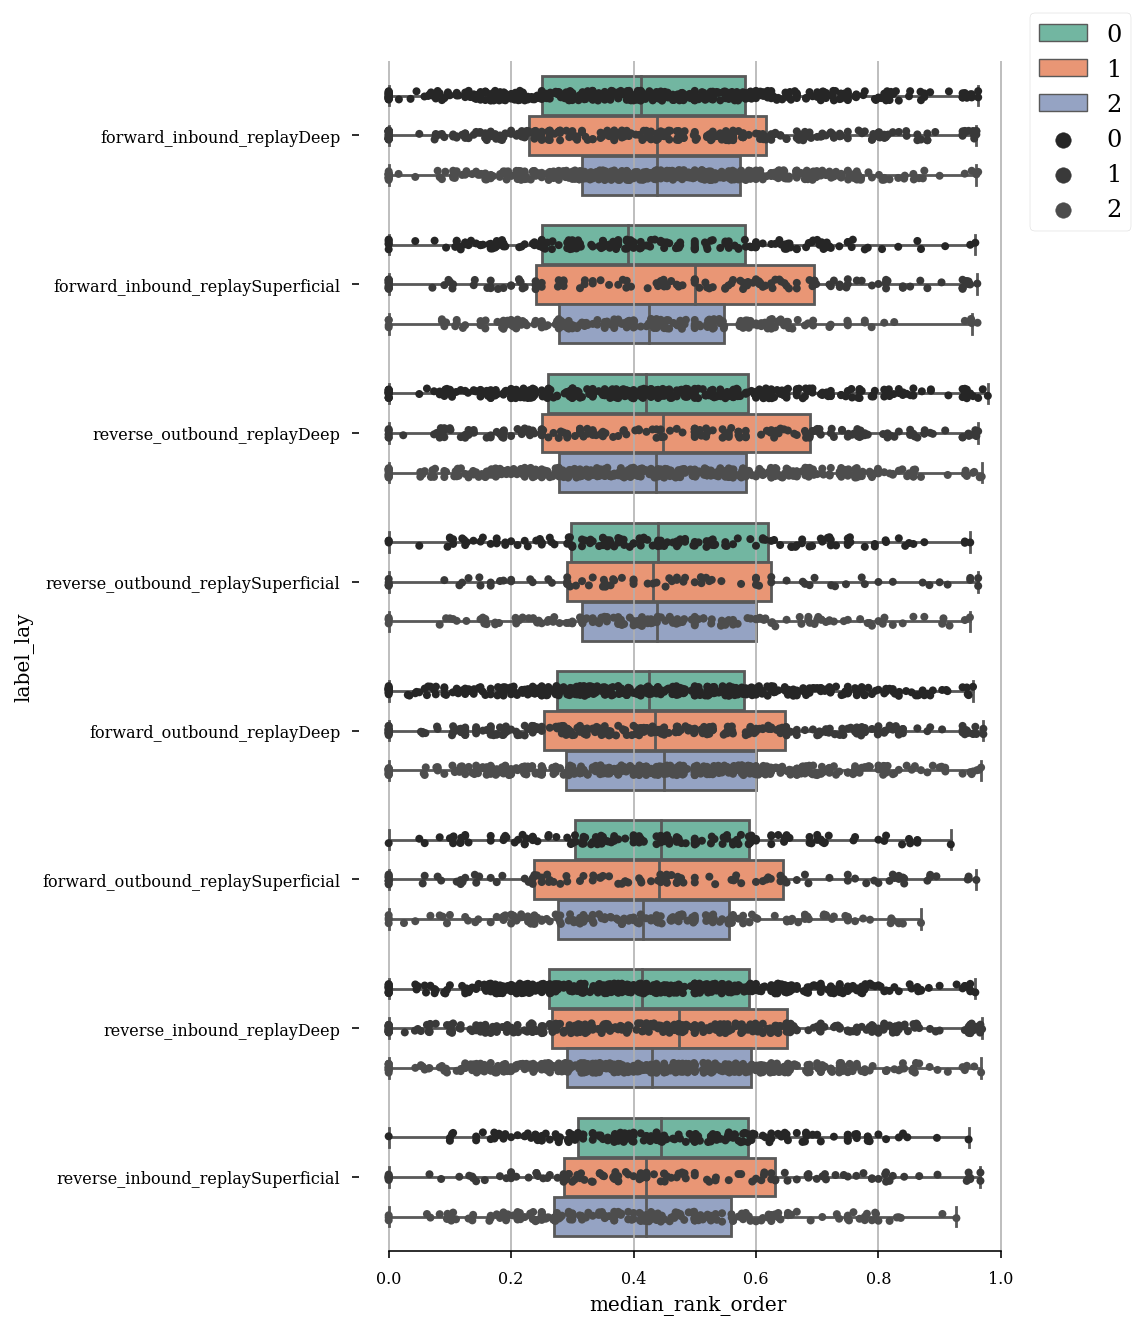

In [17]:
plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(3,1)), edgecolor=None)
ax = plt.gca()
# hue_order = ['forward_inbound_replay','reverse_outbound_replay','forward_outbound_replay','reverse_inbound_replay']

hue_order = ['forward_inbound_replayDeep','forward_inbound_replaySuperficial',
            'reverse_outbound_replayDeep','reverse_outbound_replaySuperficial',
            'forward_outbound_replayDeep','forward_outbound_replaySuperficial',
            'reverse_inbound_replayDeep','reverse_inbound_replaySuperficial']
# import matplotlib
# cmap = matplotlib.cm.get_cmap('Set2',8)
sns.set_palette(sns.color_palette('Set2',8))
sns.boxplot(data=df_rank_order,x="median_rank_order", y="label_lay",order=hue_order,hue='environment',
            ax=ax,showfliers=False)

sns.stripplot(data=df_rank_order,x="median_rank_order", y="label_lay",order=hue_order,hue='environment',
            size=4, color=".3", linewidth=0,dodge=True,ax=ax)

# sns.stripplot(x="median_rank_order", y="environment", data=df_rank_order,hue="label_lay",hue_order=hue_order,
#                 size=4, color=".3", linewidth=0,dodge=True,ax=ax)
ax.legend(bbox_to_anchor=(1, 1.05),fontsize=12)
# plt.axhline(.5,linestyle='--')
# ax = plt.gca()
ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

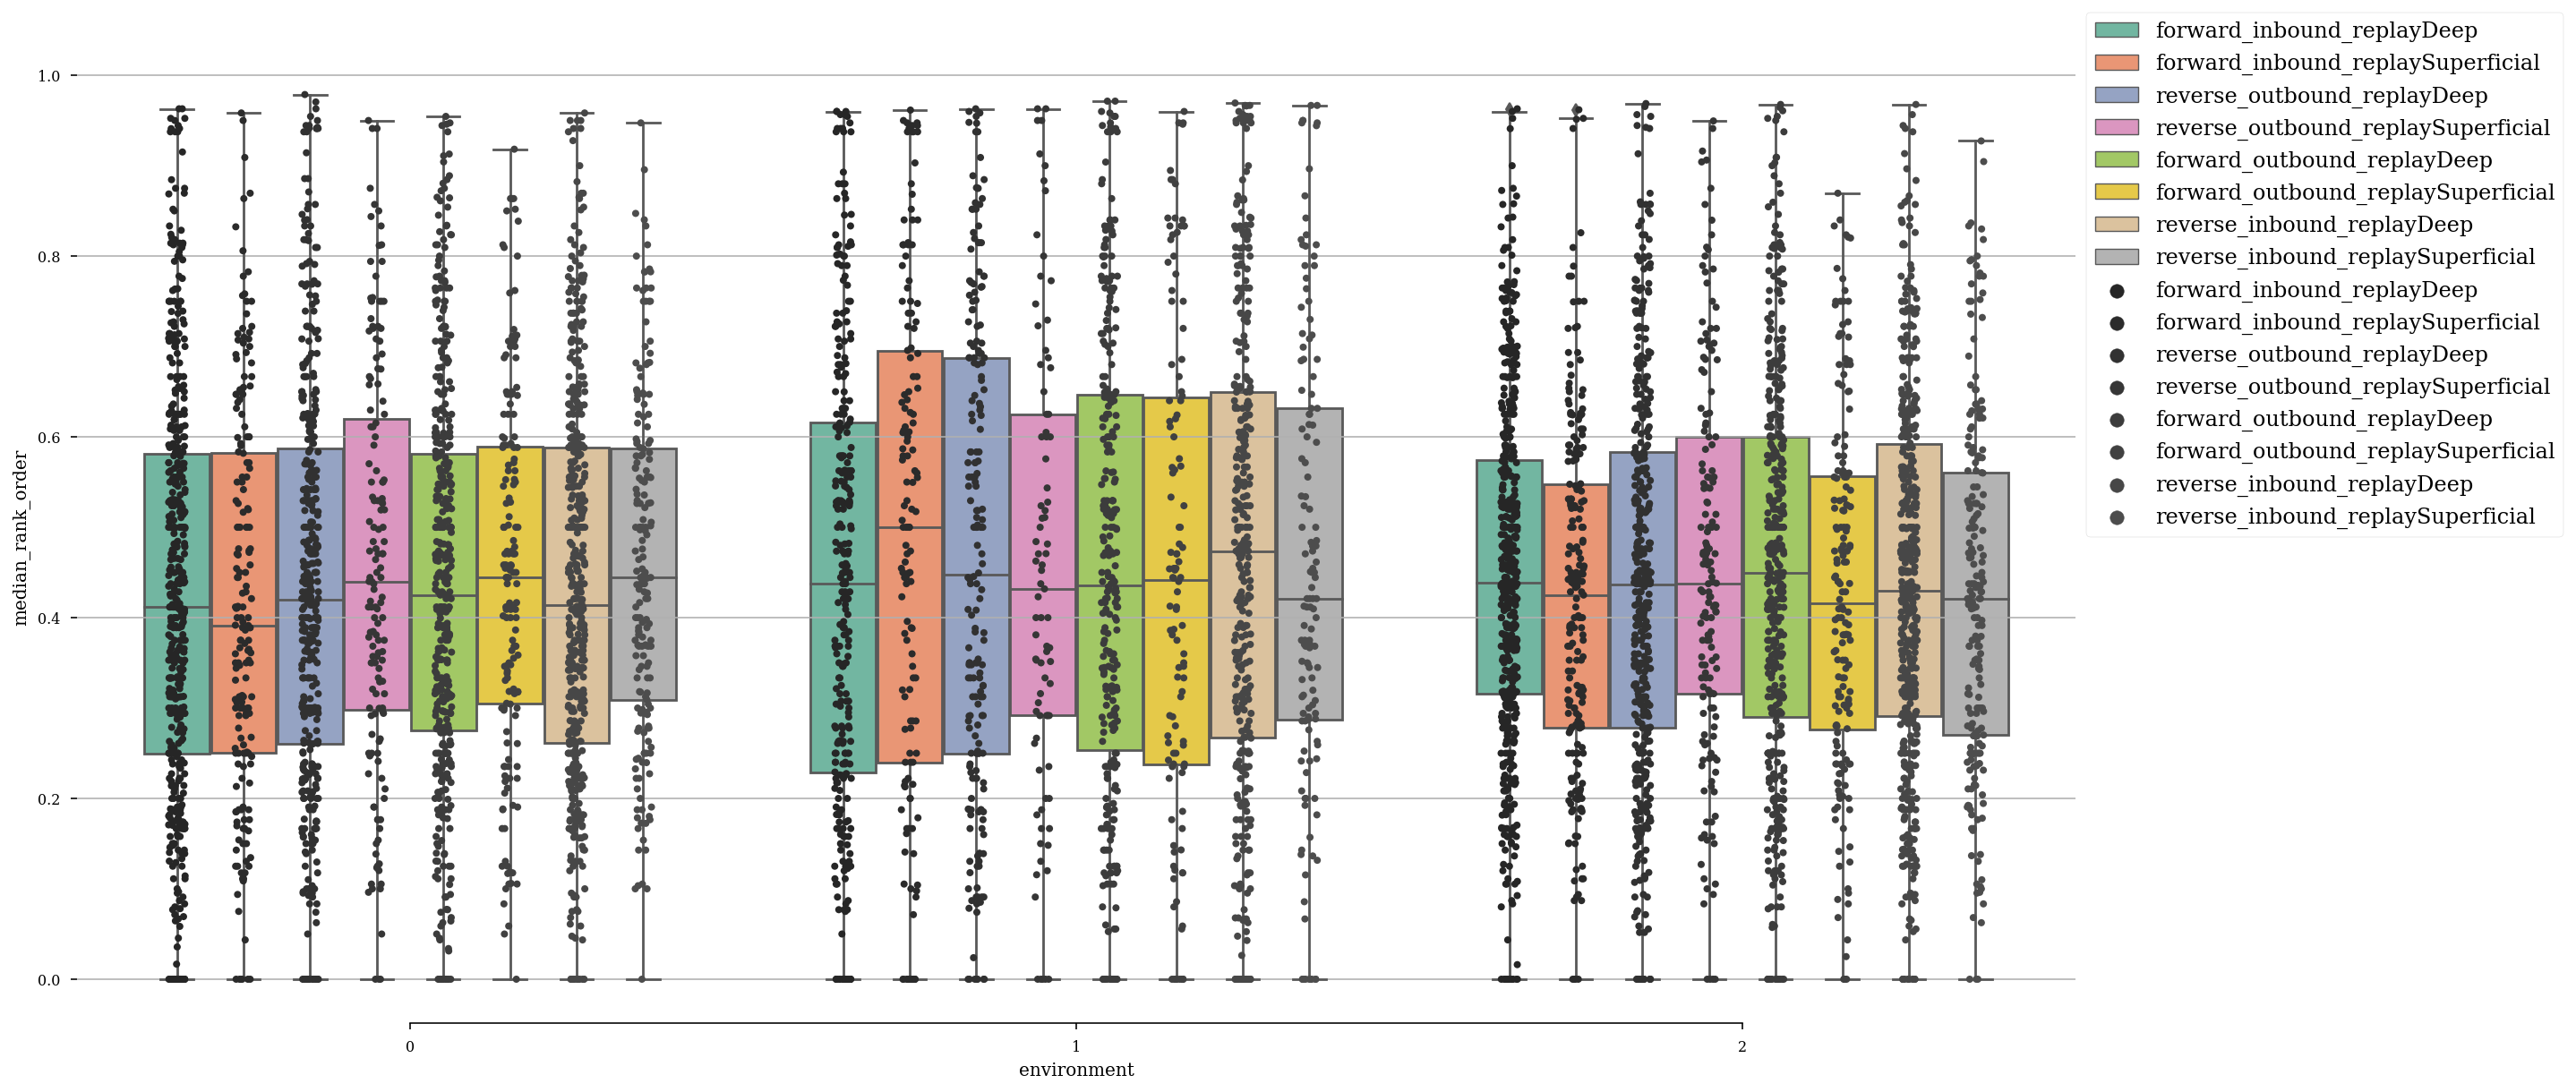

In [18]:
f, ax = plt.subplots(figsize=(20,10))

# hue_order = ['forward_inbound_replay','reverse_outbound_replay','forward_outbound_replay','reverse_inbound_replay']

hue_order = ['forward_inbound_replayDeep','forward_inbound_replaySuperficial',
            'reverse_outbound_replayDeep','reverse_outbound_replaySuperficial',
            'forward_outbound_replayDeep','forward_outbound_replaySuperficial',
            'reverse_inbound_replayDeep','reverse_inbound_replaySuperficial']

sns.boxplot(x="environment", y="median_rank_order",
            hue="label_lay",hue_order=hue_order,
            data=df_rank_order,ax=ax)

sns.stripplot(x="environment", y="median_rank_order", data=df_rank_order,hue="label_lay",hue_order=hue_order,
                size=4, color=".3", linewidth=0,dodge=True,ax=ax)
ax.legend(bbox_to_anchor=(1, 1.05),fontsize=12)
# plt.axhline(.5,linestyle='--')
# ax = plt.gca()
ax.yaxis.grid(True)
sns.despine(trim=True, left=True)

In [249]:
importlib.reload(functions)

median_rank_order = []
label = []
for key_ in  epochs.keys():
    temp_rank_order,rank_order = functions.get_rank_order(st,epochs[key_])
    median_rank_order.append(temp_rank_order)
    label.append([key_]*len(temp_rank_order))

df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered


## testing below

In [252]:
df_rank_order['label'].unique()

array(['forward_outbound_replay', 'forward_inbound_replay',
       'reverse_outbound_replay', 'reverse_inbound_replay'], dtype=object)

Text(0, 0.5, 'rank order')

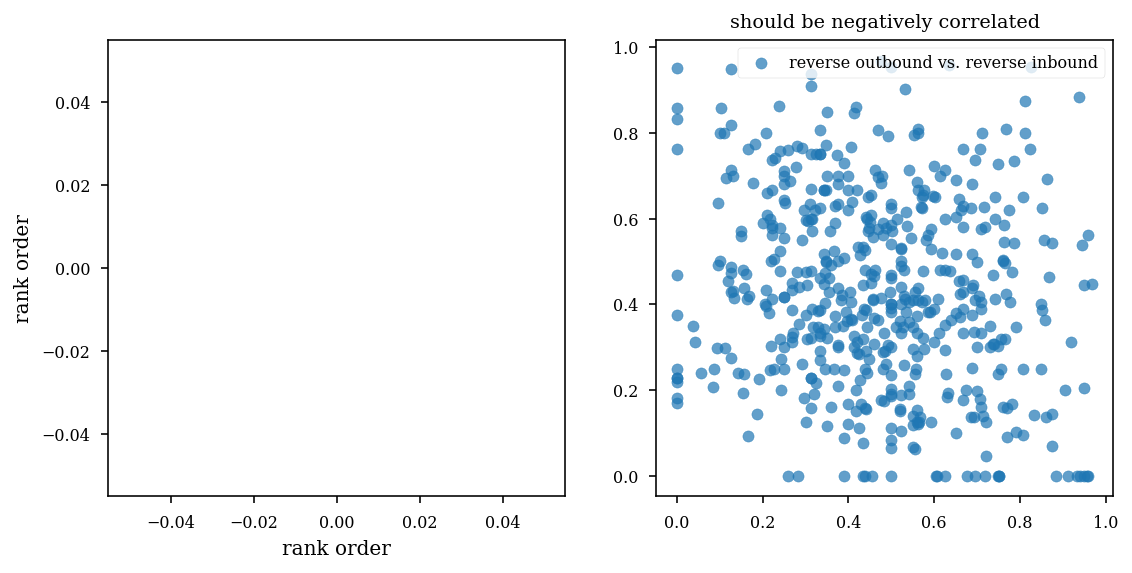

In [278]:
df_rank_order = pd.DataFrame()
df_rank_order['median_rank_order'] = np.hstack(median_rank_order)
df_rank_order['label'] = np.hstack(label)

fig,ax = plt.subplots(1,2,figsize=(9,9))

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. reverse inbound')

# ax[0].scatter(df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,alpha=.7,
#             label='forward inbound vs. reverse outbound')
# ax[0].legend()
# ax[0].set_title('should be positively correlated')

# ax[1].scatter(df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,
#             df_rank_order[df_rank_order.label == 'forward_inbound_replay'].median_rank_order,alpha=.7,
#             label='forward outbound vs. forward inbound')

ax[1].scatter(df_rank_order[df_rank_order.label == 'reverse_outbound_replay'].median_rank_order,
            df_rank_order[df_rank_order.label == 'forward_outbound_replay'].median_rank_order,alpha=.7,
            label='reverse outbound vs. reverse inbound')
ax[1].set_title('should be negatively correlated')
ax[1].legend()

ax[0].axis('square')
ax[1].axis('square')

ax[0].set_xlabel('rank order')
ax[0].set_ylabel('rank order')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6732: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\matplotlib\axes\_axes.py:6731: RuntimeWarning: All-NaN slice encountered
C:\Users\Cornell\ana

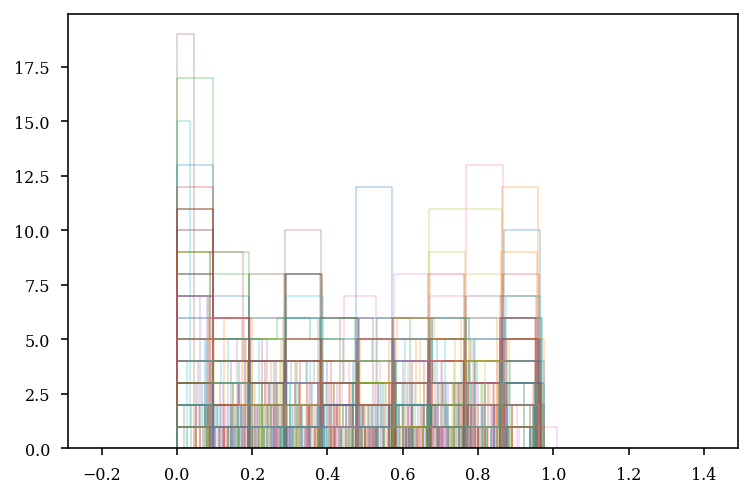

In [218]:
for i in range(rank_order.shape[0]):
    try:
        plt.hist(rank_order[i,:],histtype='step')
    except:
        pass
# plt.hist(rank_order[0,:],histtype='step')

plt.show()

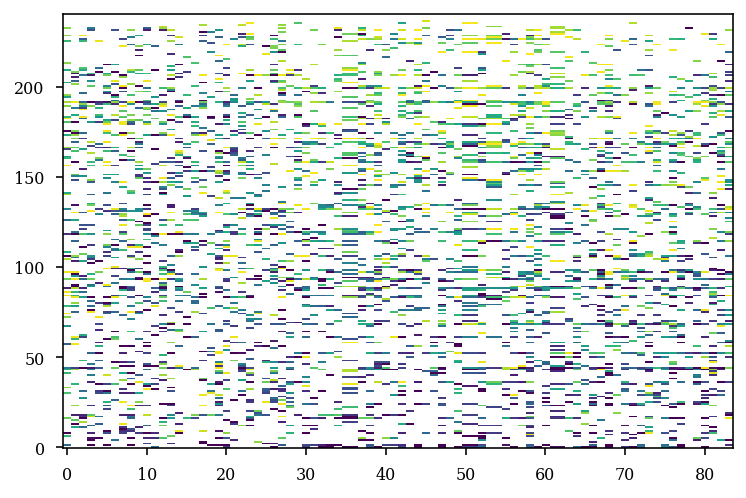

In [219]:
# plt.plot(np.sort(mean_rank))
plt.imshow(rank_order[np.argsort(mean_rank),:],aspect='auto',interpolation='nearest',origin='lower')

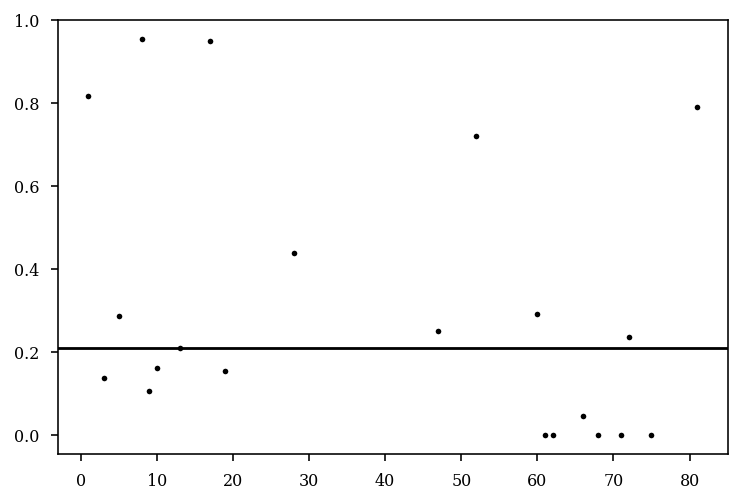

In [222]:
cell = 20
plt.plot(rank_order[cell,:],'.k')
plt.axhline(mean_rank[cell],color='k')

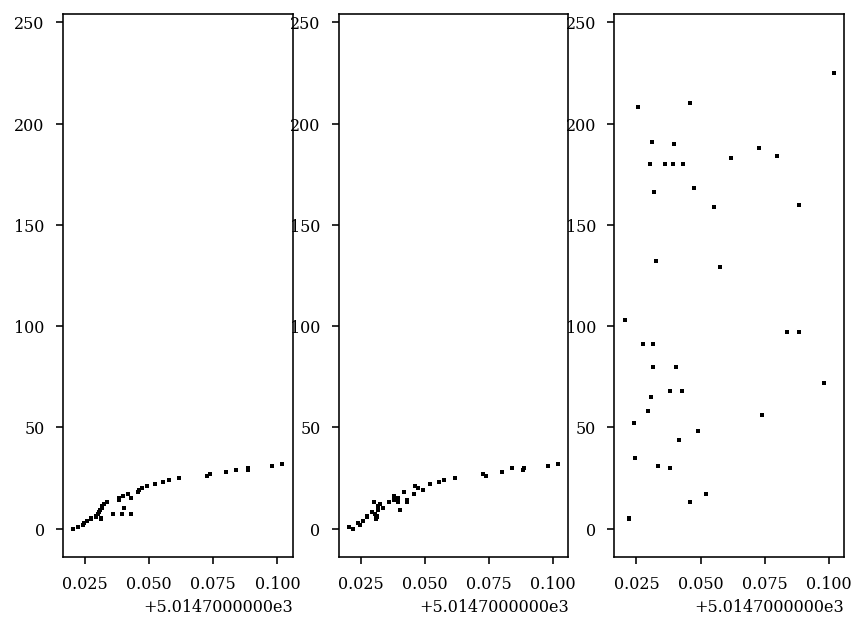

In [221]:
rip = 4

fig,ax = plt.subplots(1,3,figsize=(7,5))

order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1
ax[0].eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')

ax[1].eventplot(st[forward_replay[rip]].data[np.argsort(rank_order[:,rip])],linewidths=2,linelengths=2,color='k')

ax[2].eventplot(st[forward_replay[rip]].data[np.argsort(mean_rank)],linewidths=2,linelengths=2,color='k')

# ax[0].set_ylim(0,50)
# ax[1].set_ylim(0,50)

plt.show()

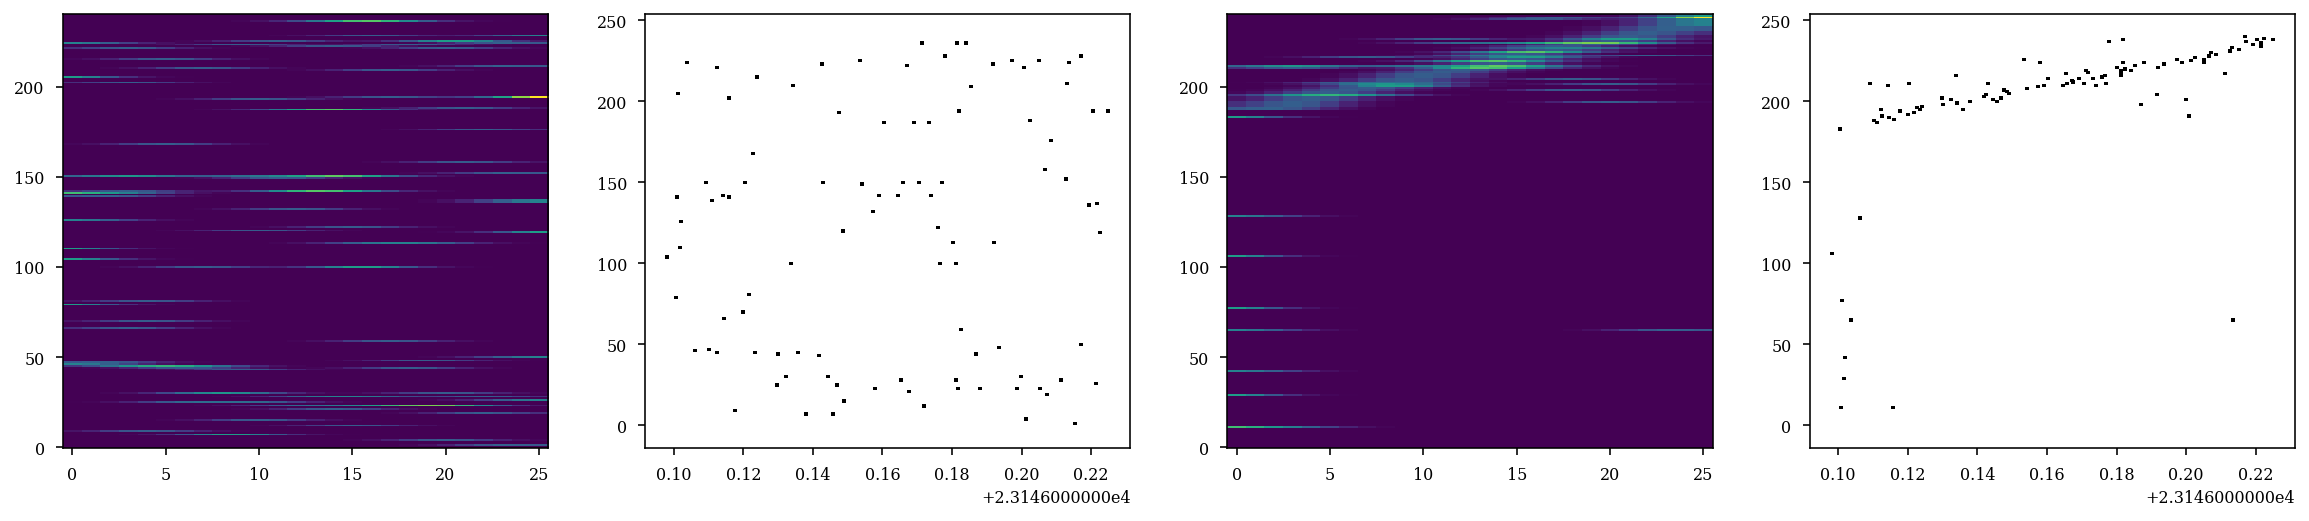

In [103]:
rip = 50
z_t = st[forward_replay[rip]].bin(ds=.005)
z_t.smooth(sigma=0.01,inplace=True)

fig,ax = plt.subplots(1,4,figsize=(20,4))
ax[0].imshow(z_t.data,aspect='auto',interpolation='nearest',origin='lower')
ax[1].eventplot(st[forward_replay[rip]].data,linewidths=2,linelengths=2,color='k')

peak_idx = []
for unit in z_t.data:
    peak_idx.append(np.argmax(unit))
reorder_idx = np.argsort(peak_idx)

ax[2].imshow(z_t.data[reorder_idx,:],aspect='auto',interpolation='nearest',origin='lower')

ax[3].eventplot(st[forward_replay[rip]].data[reorder_idx],linewidths=2,linelengths=2,color='k')
plt.show()

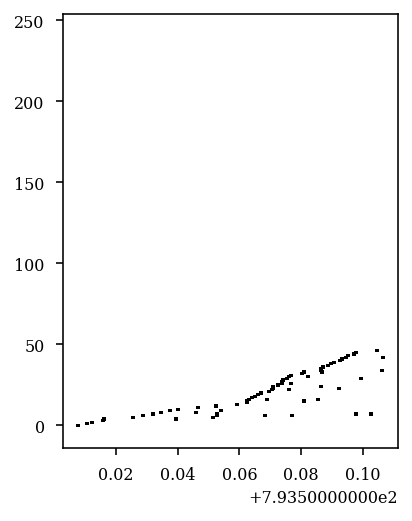

In [52]:
rip = 0
order_idx = np.array(st[forward_replay[rip]].get_event_firing_order())-1

plt.figure(figsize=(3,4))
plt.eventplot(st[forward_replay[rip]].data[order_idx],linewidths=2,linelengths=2,color='k')
plt.show()

# plt.figure()
# ax = plt.gca()
# raster_lw=2
# raster_lh=2
# npl.rasterplot(st[forward_replay[0]], vertstack=True, ax=ax, lh=raster_lh,lw=raster_lw)


In [27]:
results.keys()

dict_keys(['outbound_epochs', 'inbound_epochs'])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


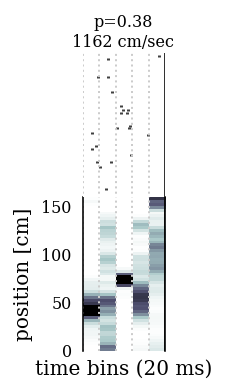

In [33]:
# importlib.reload(replay_fig)
import replay_fig
idxs = np.where((results['outbound_epochs']['df']['score_pval_col_cycle']<0.05))[0]
idx = idxs[0]
idx = int(idx)
if isinstance(idx, int):
    title = "p={:.2f}\n{:.0f} cm/sec".format(results['outbound_epochs']['df'].trajectory_score.iloc[idx],
                                             results['outbound_epochs']['df'].traj_speed.iloc[idx])
else:
    title = ""
ax = replay_fig.plot_all_replay(results['outbound_epochs']['bst_placecells'][idx],
                                        results['outbound_epochs']['sta_placecells'],
                                        results['outbound_epochs']['tc'],
                                        results['outbound_epochs']['tc'],
                                        vmax=.1,
                                        title_str=title) 